,max_steps,timehorizon,best_reward,avg_reward,std_reward
0,100,1,0.330971,0.257148,0.063171
1,100,2,0.340746,0.240206,0.068752
2,100,3,0.310576,0.256795,0.033525
3,100,4,0.303318,0.222159,0.088310
4,100,5,0.405637,0.308071,0.069116


Shape: (28, 5)
Columns: ['max_steps', 'timehorizon', 'best_reward', 'avg_reward', 'std_reward']
Metric columns: ['best_reward', 'avg_reward', 'std_reward']


,metric,corr_with_max_steps,corr_with_timehorizon
1,avg_reward,0.576664,0.324141
0,best_reward,0.760680,0.228397
2,std_reward,0.812851,0.102436


,metric,max_value,best_max_steps,best_timehorizon
1,avg_reward,0.662960,300,8
0,best_reward,1.000000,300,2
2,std_reward,0.463216,500,5


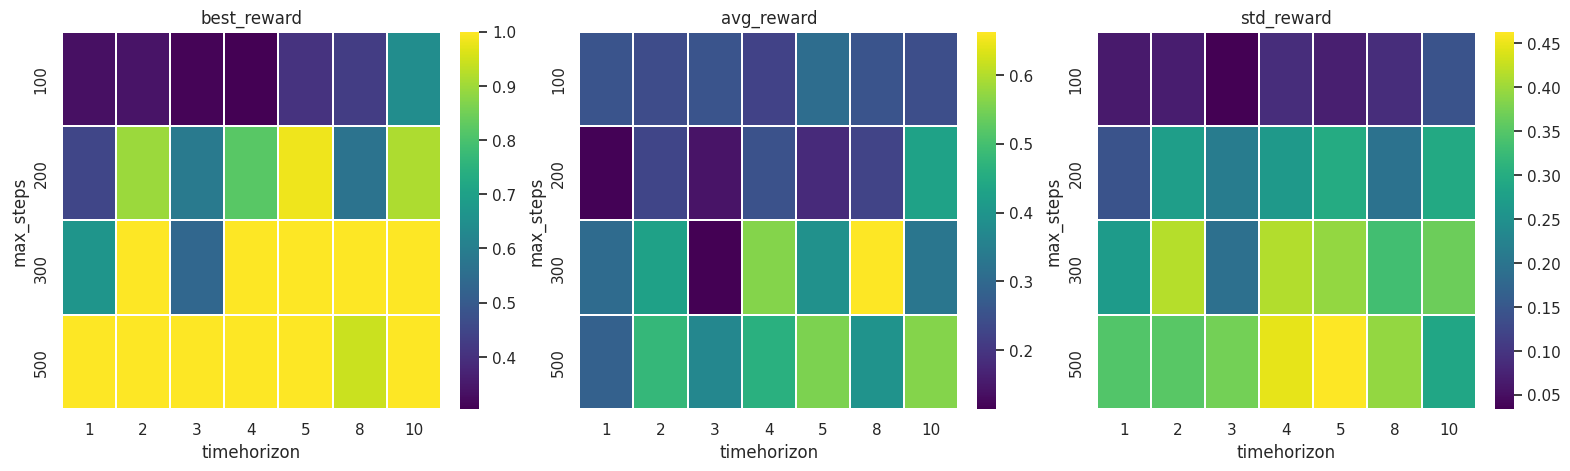

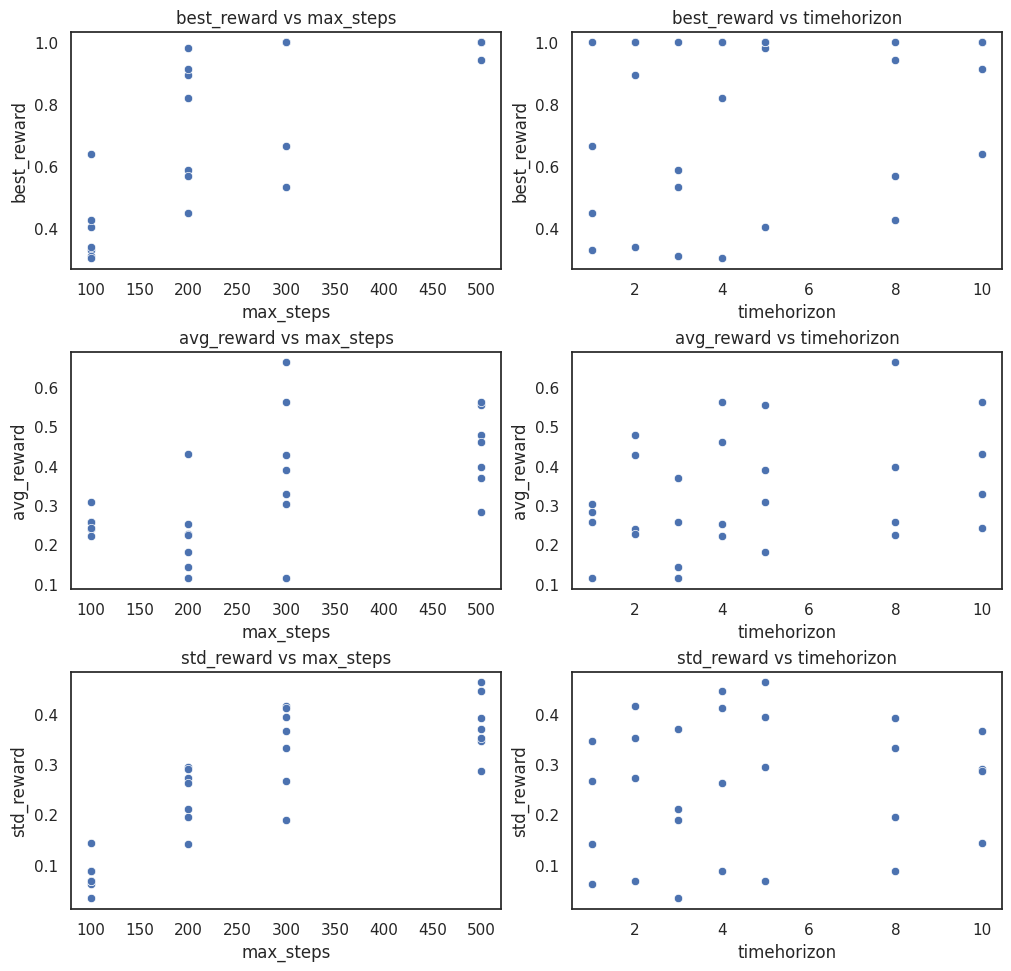

In [5]:
# Jupyter notebook code: load grid search CSV, compute correlations, and plot heatmaps
# File columns: max_steps, timehorizon, best_reward, avg_reward, std_reward [file:1]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Load data ---
csv_path = "./grid_search_results_20260114_213245.csv"
df = pd.read_csv(csv_path)

# Basic sanity checks
display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Ensure hyperparameters are treated as numeric
df["max_steps"] = pd.to_numeric(df["max_steps"])
df["timehorizon"] = pd.to_numeric(df["timehorizon"])

# Metrics = all columns except the two hyperparameters
hp_cols = ["max_steps", "timehorizon"]
metric_cols = [c for c in df.columns if c not in hp_cols]
print("Metric columns:", metric_cols)

# --- 2) Correlations of each metric with each hyperparameter (Pearson) ---
corr_rows = []
for m in metric_cols:
    corr_rows.append({
        "metric": m,
        "corr_with_max_steps": df[[ "max_steps", m]].corr(method="pearson").iloc[0, 1],
        "corr_with_timehorizon": df[["timehorizon", m]].corr(method="pearson").iloc[0, 1],
    })
corr_df = pd.DataFrame(corr_rows).sort_values("metric")
display(corr_df)

# Optionally save
corr_df.to_csv("correlations.csv", index=False)

# --- 3) Find argmax per metric (best cell in grid) ---
best_rows = []
for m in metric_cols:
    idx = df[m].idxmax()
    best_rows.append({
        "metric": m,
        "max_value": df.loc[idx, m],
        "best_max_steps": int(df.loc[idx, "max_steps"]),
        "best_timehorizon": int(df.loc[idx, "timehorizon"]),
    })
best_df = pd.DataFrame(best_rows).sort_values("metric")
display(best_df)

best_df.to_csv("metric_maxima.csv", index=False)

# --- 4) Heatmaps: one per metric, axes = (max_steps, timehorizon) ---
sns.set_theme(style="white", font_scale=1.0)

# Sort axes for consistent layout
max_steps_sorted = np.sort(df["max_steps"].unique())
timehorizon_sorted = np.sort(df["timehorizon"].unique())

n = len(metric_cols)
fig, axes = plt.subplots(1, n, figsize=(5.2 * n, 4.6), constrained_layout=True)

# Handle case with only one metric
if n == 1:
    axes = [axes]

for ax, m in zip(axes, metric_cols):
    pivot = (
        df.pivot(index="max_steps", columns="timehorizon", values=m)
          .reindex(index=max_steps_sorted, columns=timehorizon_sorted)
    )

    sns.heatmap(
        pivot,
        ax=ax,
        cmap="viridis",
        annot=False,
        linewidths=0.3,
        linecolor="white",
        cbar=True
    )
    ax.set_title(m)
    ax.set_xlabel("timehorizon")
    ax.set_ylabel("max_steps")

plt.show()

# --- 5) Optional: scatterplots to show correlation trends directly ---
fig, axes = plt.subplots(len(metric_cols), 2, figsize=(10, 3.2 * len(metric_cols)), constrained_layout=True)

for i, m in enumerate(metric_cols):
    sns.scatterplot(data=df, x="max_steps", y=m, ax=axes[i, 0])
    axes[i, 0].set_title(f"{m} vs max_steps")

    sns.scatterplot(data=df, x="timehorizon", y=m, ax=axes[i, 1])
    axes[i, 1].set_title(f"{m} vs timehorizon")

plt.show()
